In [1]:
# 导入模块
%matplotlib inline
import torch
import numpy as np
import pylab as pl
from torch import nn

In [ ]:
# 验证单纯通过改变张量形状，无法增加神经网络拟合能力
np.random.seed(1)
X = np.random.randint(0,10,[2,3,4])
W = np.random.randint(0,10,[3,4,5])
print('X=\n{}'.format(X))
print('W=\n{}'.format(W))
print('X.W=\n{}'.format(np.tensordot(X,W,[[1,2],[0,1]])))

X1 = X.reshape([2,-1])
W1 = W.reshape([-1,5])
print('X1=\n{}'.format(X1))
print('W1=\n{}'.format(W1))
print('X1.W1=\n{}'.format(np.tensordot(X1,W1,[[-1],[0]])))

In [ ]:
# 全手工打造一个线性层
class Linear_DIY():
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weight = nn.Parameter(torch.randn(input_size, output_size)) # W
        self.bias = nn.Parameter(torch.randn(output_size)) # B
    def __call__(self, x):
        self.input = x
        self.output = torch.mm(self.input,self.weight)
        self.output += self.bias.unsqueeze(0).expand_as(self.output)
        return self.output
    def step(self, lr=1e-3):
        self.weight.data -= lr * self.weight.grad
        self.bias.data -= lr * self.bias
        self.weight.grad.data.zero_()
        self.bias.grad.data.zero_()
        
lr = 1e-2
batch_size = 5
input_size = 10
output_size = 2
data_size = 500

torch.manual_seed(1)
np.random.seed(1)

x_data = torch.randn(data_size,input_size) # the x dataset
W = torch.randn(input_size,output_size)
y_data = torch.mm(x_data,W)

linear = Linear_DIY(input_size, output_size)

Losses = []
for epoch in range(2000):
    sample_indices = np.random.randint(0,data_size,batch_size)
    x = x_data[sample_indices]
    x = linear(x)
    y = y_data[sample_indices]
    loss = torch.mean((x-y)**2)
    loss.backward()
    Losses.append(loss.detach().tolist())
    linear.step(lr=lr)
window_size = 20
pl.plot(np.arange(0,len(Losses),window_size),torch.mean(torch.reshape(torch.Tensor(Losses),[-1,window_size]),1).numpy(),'r-')
pl.xlabel('Time')
pl.ylabel('Loss')
pl.yscale('log')

Epoch 0, Loss 0.774970471859
Epoch 500, Loss 0.764719247818
Epoch 1000, Loss 0.653539597988
Epoch 1500, Loss 0.483682721853
Epoch 2000, Loss 0.344740003347
Epoch 2500, Loss 0.269992828369
Epoch 3000, Loss 0.165099278092
Epoch 3500, Loss 0.247723400593
Epoch 4000, Loss 0.0480613596737
Epoch 4500, Loss 0.0374013148248
Epoch 5000, Loss 0.054117269814
Epoch 5500, Loss 0.0145861972123
Epoch 6000, Loss 0.0200360007584
Epoch 6500, Loss 0.0140474941581
Epoch 7000, Loss 0.00766546558589
Epoch 7500, Loss 0.0166953802109
Epoch 8000, Loss 0.00970554817468
Epoch 8500, Loss 0.0028621358797
Epoch 9000, Loss 0.00299871363677
Epoch 9500, Loss 0.0018240318168
Epoch 10000, Loss 0.00241611339152
Epoch 10500, Loss 0.00253213313408
Epoch 11000, Loss 0.00107213482261
Epoch 11500, Loss 0.000686304294504
Epoch 12000, Loss 0.00170988973696
Epoch 12500, Loss 0.000621513754595
Epoch 13000, Loss 0.000364996725693
Epoch 13500, Loss 0.000413099653088
Epoch 14000, Loss 0.00077027885709
Epoch 14500, Loss 0.00041307846

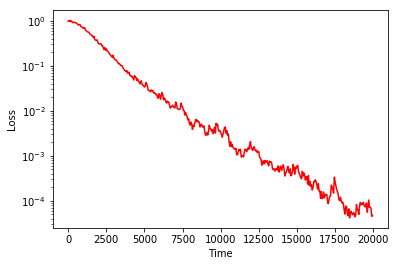

In [54]:
# 研究广度和深度的影响
lr = 1e-3
batch_size = 5
input_size = 10
output_size = 10
hidden_size = 128 # 16 64 256
data_size = 500
n_epochs = 20000

n_hidden = 3
activation = torch.relu

torch.manual_seed(1)
np.random.seed(1)

x_data = torch.randn(data_size,input_size)
y_data = torch.randn(data_size,output_size)

class DNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_hidden=1, activation=None):
        super(DNN,self).__init__()
        self.input = nn.Linear(input_size, hidden_size)
        hiddens = []
        self.n_hidden = n_hidden
        self.activation = activation
        for n in range(self.n_hidden):
            hiddens.append(nn.Linear(hidden_size, hidden_size))
        self.hiddens = nn.Sequential(*hiddens)
        self.output = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.input(x)
        if self.activation is not None:
            x = self.activation(x)
        for i in range(self.n_hidden):
            x = self.hiddens[i](x)
            if self.activation is not None:
                x = self.activation(x)
        return self.output(x)

model = DNN(input_size, output_size, hidden_size, n_hidden=n_hidden, activation=activation)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

def lr_lambda(epoch):
    return 0.99**(epoch/50.0)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)

loss_func = torch.nn.MSELoss()
Losses = []
display_interval = 50

W_input = []
W_hidden = []
W_output = []
W_all = []
for epoch in range(n_epochs):
    model.zero_grad()
    sample_indices = np.random.randint(0,data_size,batch_size)
    x = x_data[sample_indices]
    x = model(x)
    y = y_data[sample_indices]
    loss = loss_func(x,y)
    loss.backward()
    Losses.append(loss.detach().tolist())
    optimizer.step()
    scheduler.step()
    if epoch % 500 == 0: print('Epoch {}, Loss {}'.format(epoch, Losses[-1]))
window_size = 50

avg_losses = np.array(Losses).reshape([-1,window_size]).mean(1)
#np.save('saves/hidden_size_'+str(hidden_size)+'_with_activation.npy', avg_losses)

pl.plot(np.arange(0,len(Losses),window_size), avg_losses,'r-')
pl.xlabel('Time')
pl.ylabel('Loss')
pl.yscale('log')

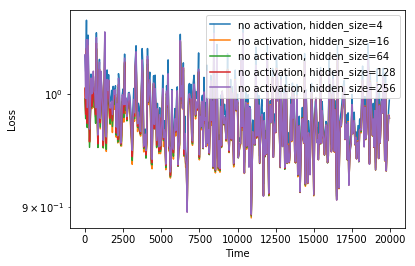

In [50]:
fig = pl.figure(figsize=(6,4))
fig.clf()
for n in [4,16,64,128,256]:
    avg_losses = np.load('saves/hidden_size_'+str(n)+'_no_activation.npy')
    pl.plot(np.arange(0,n_epochs,window_size), avg_losses, label='no activation, hidden_size={}'.format(n))
pl.legend(loc='best')
pl.xlabel('Time')
pl.ylabel('Loss')
pl.yscale('log')

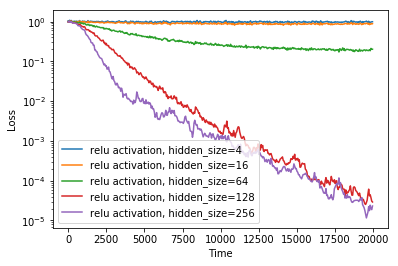

In [53]:
fig = pl.figure(figsize=(6,4))
fig.clf()
for n in [4,16,64,128,256]:
    avg_losses = np.load('saves/hidden_size_'+str(n)+'_with_activation.npy')
    pl.plot(np.arange(0,n_epochs,window_size), avg_losses, label='relu activation, hidden_size={}'.format(n))
pl.legend(loc='best')
pl.xlabel('Time')
pl.ylabel('Loss')
pl.yscale('log')